## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [6]:
# Make sure to change path if you put the zip elsewhere
!unzip chest_xray.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/pneumonia/person1608_bacteria_4235.jpeg  
  inflating: chest_xray/train/pneumonia/person445_virus_916.jpeg  
  inflating: chest_xray/train/pneumonia/person302_bacteria_1430.jpeg  
  inflating: chest_xray/train/pneumonia/person1188_bacteria_3137.jpeg  
  inflating: chest_xray/train/pneumonia/person353_virus_728.jpeg  
  inflating: chest_xray/train/pneumonia/person348_bacteria_1602.jpeg  
  inflating: chest_xray/train/pneumonia/person1272_bacteria_3232.jpeg  
  inflating: chest_xray/train/pneumonia/person1294_virus_2222.jpeg  
  inflating: chest_xray/train/pneumonia/person3_bacteria_12.jpeg  
  inflating: chest_xray/train/pneumonia/person124_virus_234.jpeg  
  inflating: chest_xray/train/pneumonia/person378_virus_761.jpeg  
  inflating: chest_xray/train/pneumonia/person1478_bacteria_3848.jpeg  
  inflating: chest_xray/train/pneumonia/person1446_bacteria_3740.jpeg  
  inflating: chest_xray/train/pneumonia/per

## Create dataset from directory

In [7]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


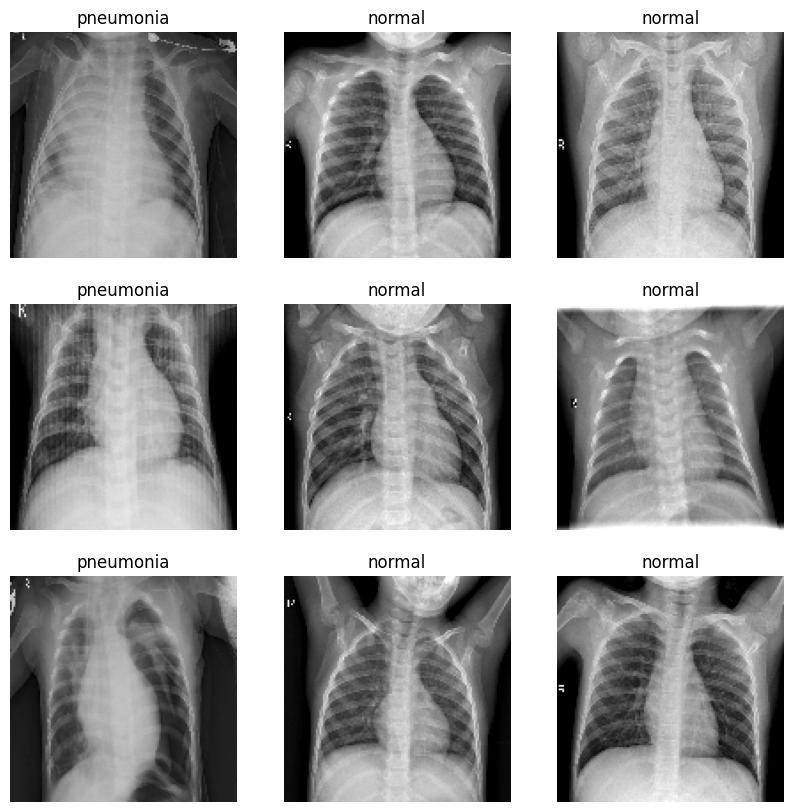

In [8]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [9]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

In [10]:
class_weights

{0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}

## Create CNN model

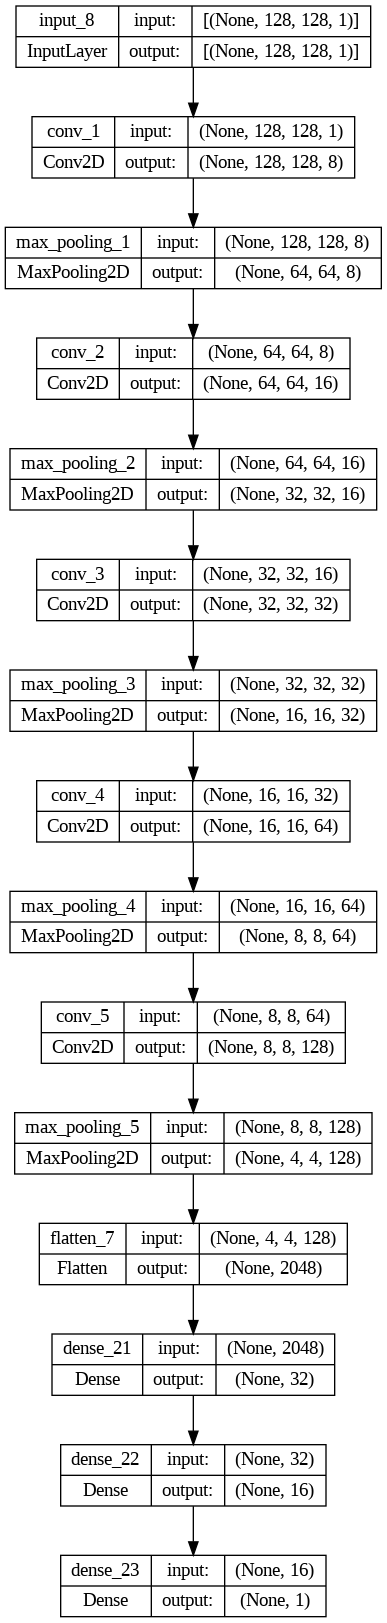

In [26]:
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses
)

# Define CNN model
input_8 = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))

# First block: conv_1 + max_pooling_1
conv_1 = layers.Conv2D(8, kernel_size=3, padding='same', activation='relu', name='conv_1')(input_8)
max_pooling_1 = layers.MaxPooling2D(pool_size=2, name='max_pooling_1')(conv_1)

# Second block: conv_2 + max_pooling_2
conv_2 = layers.Conv2D(16, kernel_size=3, padding='same', activation='relu', name='conv_2')(max_pooling_1)
max_pooling_2 = layers.MaxPooling2D(pool_size=2, name='max_pooling_2')(conv_2)

# Third block: conv_3 + max_pooling_3
conv_3 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv_3')(max_pooling_2)
max_pooling_3 = layers.MaxPooling2D(pool_size=2, name='max_pooling_3')(conv_3)

# Fourth block: conv_4 + max_pooling_4
conv_4 = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu', name='conv_4')(max_pooling_3)
max_pooling_4 = layers.MaxPooling2D(pool_size=2, name='max_pooling_4')(conv_4)

# Fifth block: conv_5 + max_pooling_5
conv_5 = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='conv_5')(max_pooling_4)
max_pooling_5 = layers.MaxPooling2D(pool_size=2, name='max_pooling_5')(conv_5)

# Flatten layer
flatten_7 = layers.Flatten(name='flatten_7')(max_pooling_5)

# Dense layers
dense_21 = layers.Dense(32, activation='relu', name='dense_21')(flatten_7)
dense_22 = layers.Dense(16, activation='relu', name='dense_22')(dense_21)
dense_23 = layers.Dense(1, activation='sigmoid', name='dense_23')(dense_22)

cnn = Model(inputs=input_8, outputs=dense_23)

# Compile CNN model
cnn.compile(optimizer=optimizers.Adam(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

# Display CNN model summary
cnn.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 128, 128, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_1 (MaxPooling2D)    │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2 (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_3 (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_4 (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_5 (MaxPooling2D)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,353 (642.00 KB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 0 (0.00 B)

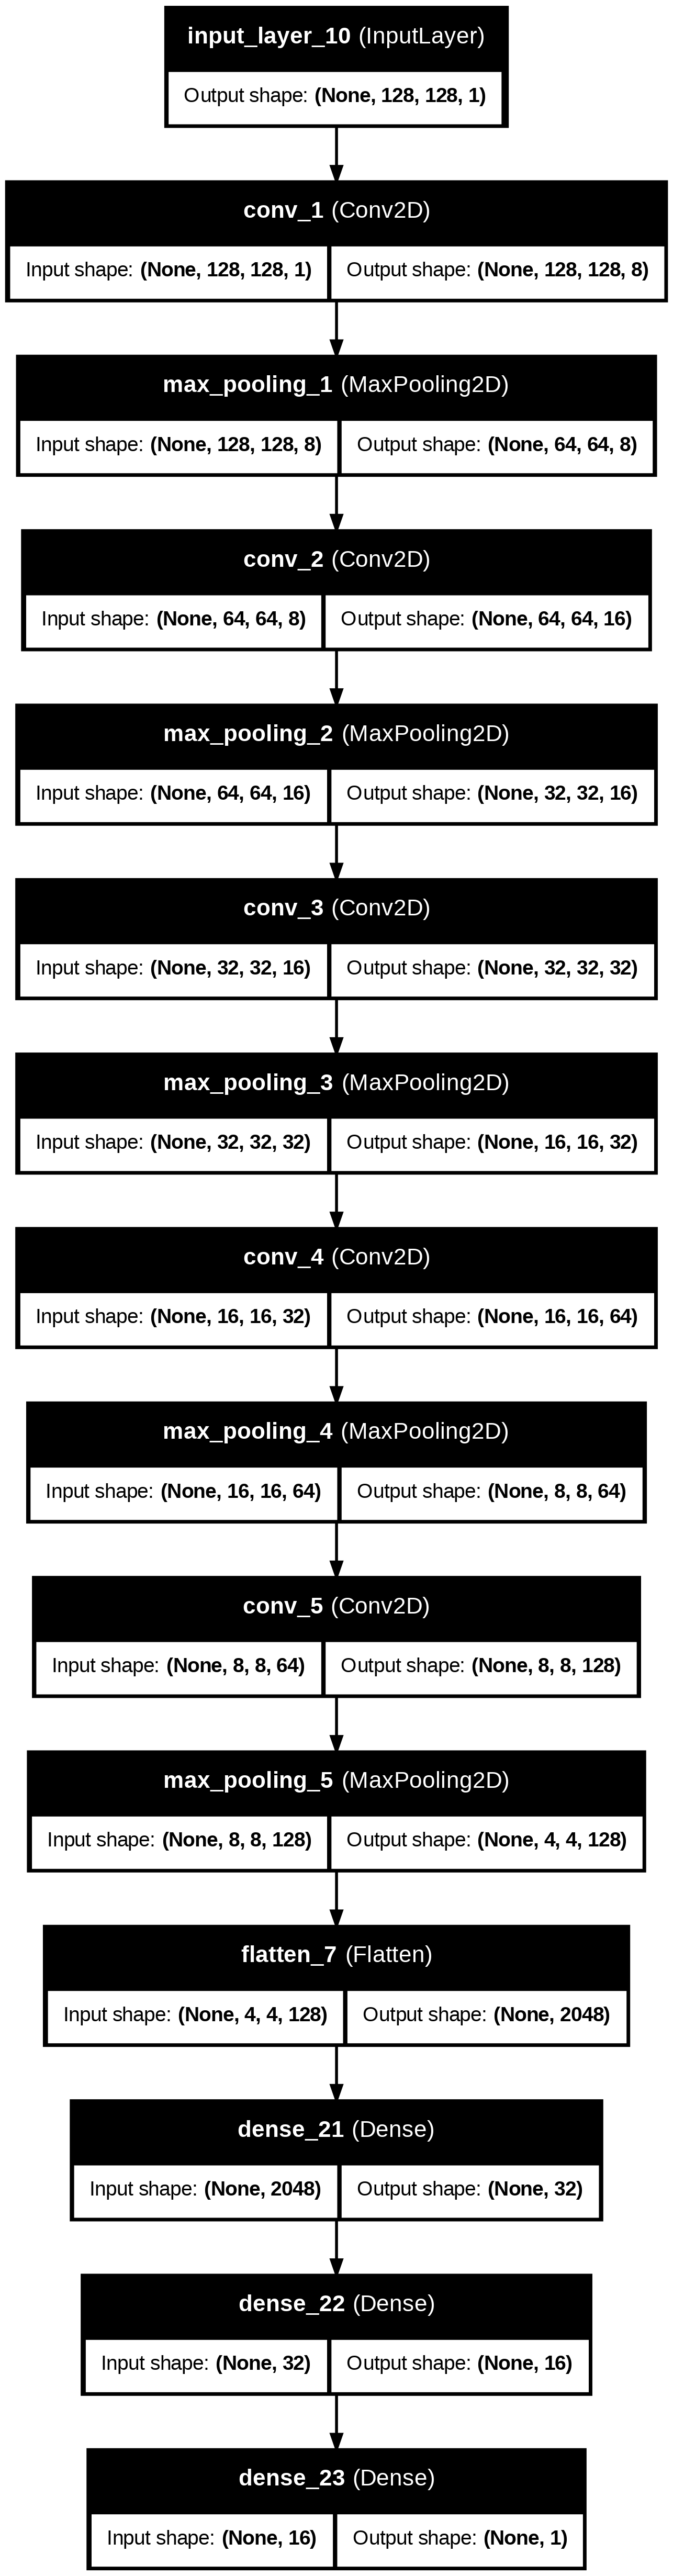

In [27]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

In [28]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights
)

Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 79s 904ms/step - accuracy: 0.6968 - loss: 0.9052 - val_accuracy: 0.6250 - val_loss: 0.5879
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 75s 908ms/step - accuracy: 0.9391 - loss: 0.1592 - val_accuracy: 0.9375 - val_loss: 0.1588
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 909ms/step - accuracy: 0.9601 - loss: 0.0971 - val_accuracy: 1.0000 - val_loss: 0.0498
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 74s 893ms/step - accuracy: 0.9720 - loss: 0.0675 - val_accuracy: 0.8750 - val_loss: 0.1999
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 83s 907ms/step - accuracy: 0.9753 - loss: 0.0709 - val_accuracy: 1.0000 - val_loss: 0.0489


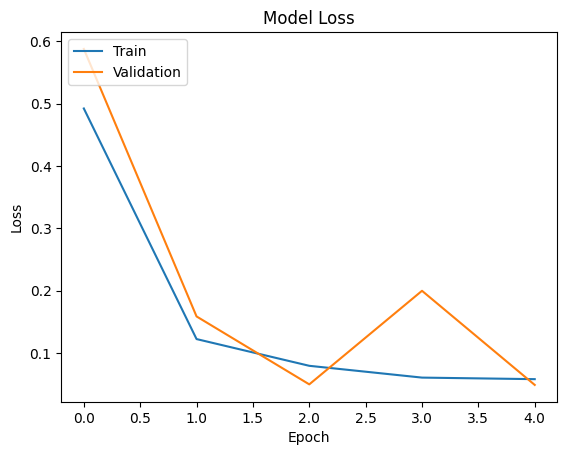

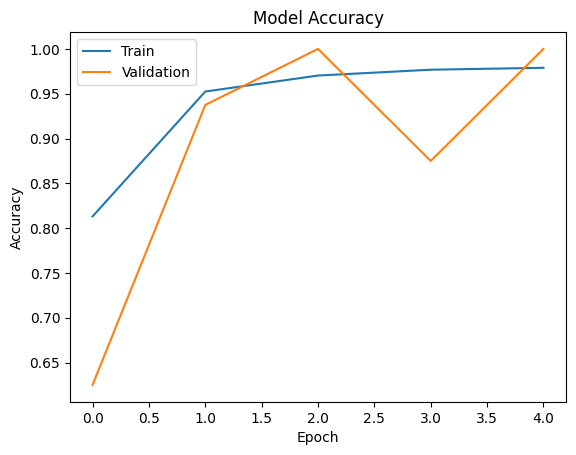

In [29]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
Validation Set Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Test Set Metrics:
Accuracy: 0.7949
Precision: 0.7569
Recall: 0.9897
F1 Score: 0.8578


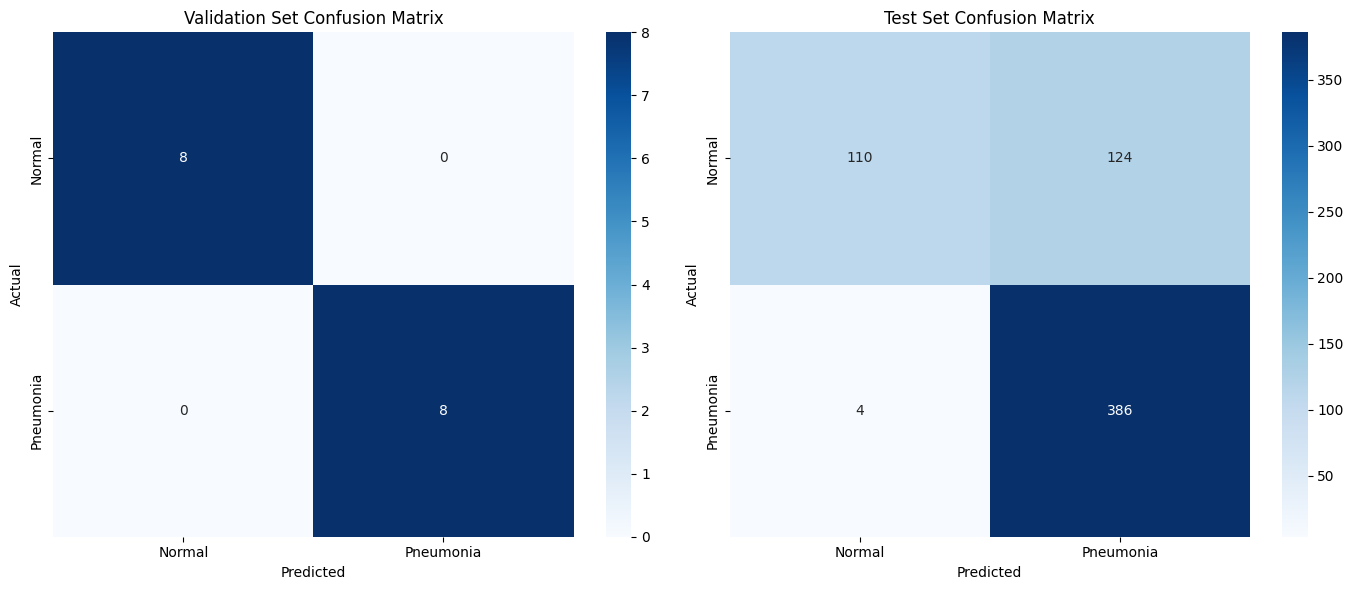


Validation Set Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         8
   Pneumonia       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16


Test Set Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.47      0.63       234
   Pneumonia       0.76      0.99      0.86       390

    accuracy                           0.79       624
   macro avg       0.86      0.73      0.74       624
weighted avg       0.83      0.79      0.77       624



In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Process validation dataset
val_images = []
val_labels = []

for img, label in val_ds:
    val_images.append(img.numpy())
    val_labels.append(label.numpy())

val_images = np.vstack(val_images)
val_labels = np.concatenate(val_labels).astype(int)

# Get predictions for validation set
val_preds = cnn.predict(val_images)
val_preds_binary = (val_preds > 0.5).astype(int).squeeze()

# Process test dataset
test_images = []
test_labels = []

for img, label in test_ds:
    test_images.append(img.numpy())
    test_labels.append(label.numpy())

test_images = np.vstack(test_images)
test_labels = np.concatenate(test_labels).astype(int)

# Get predictions for test set
test_preds = cnn.predict(test_images)
test_preds_binary = (test_preds > 0.5).astype(int).squeeze()

# Create confusion matrices
val_cm = confusion_matrix(val_labels, val_preds_binary)
test_cm = confusion_matrix(test_labels, test_preds_binary)

# Compute metrics for validation set
val_accuracy = accuracy_score(val_labels, val_preds_binary)
val_precision = precision_score(val_labels, val_preds_binary)
val_recall = recall_score(val_labels, val_preds_binary)
val_f1 = f1_score(val_labels, val_preds_binary)

# Compute metrics for test set
test_accuracy = accuracy_score(test_labels, test_preds_binary)
test_precision = precision_score(test_labels, test_preds_binary)
test_recall = recall_score(test_labels, test_preds_binary)
test_f1 = f1_score(test_labels, test_preds_binary)

# Print metrics
print("Validation Set Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")
print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Validation confusion matrix
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'],
            ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Validation Set Confusion Matrix')

# Test confusion matrix
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'],
            ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Test Set Confusion Matrix')

plt.tight_layout()
plt.show()

# Print classification reports for more detailed metrics
print("\nValidation Set Classification Report:")
print(classification_report(val_labels, val_preds_binary, target_names=['Normal', 'Pneumonia']))

print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds_binary, target_names=['Normal', 'Pneumonia']))

# Calculate additional metrics - specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

val_specificity = specificity(val_labels, val_preds_binary)
test_specificity = specificity(test_labels, test_preds_binary)